In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
%store -r df

In [3]:
df.head()

,category,time started,time ended,duration_seconds,duration_minutes
0,Сон,2024-09-01 08:57:24,2024-09-01 09:00:34,190.0,3.17
1,Сон,2024-09-01 09:00:41,2024-09-01 09:08:00,439.0,7.32
2,Сон,2024-09-01 09:18:55,2024-09-01 09:40:44,1309.0,21.82
3,Еда,2024-09-01 09:53:56,2024-09-01 11:20:33,5197.0,86.62
4,Прогулка,2024-09-01 11:20:55,2024-09-01 11:25:59,304.0,5.07


In [4]:
# проверка наличия пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   category          2509 non-null   string        
 1   time started      2509 non-null   datetime64[ns]
 2   time ended        2509 non-null   datetime64[ns]
 3   duration_seconds  2509 non-null   float64       
 4   duration_minutes  2509 non-null   float64       
dtypes: datetime64[ns](2), float64(2), string(1)
memory usage: 98.1 KB


In [5]:
df.describe()

,time started,time ended,duration_seconds,duration_minutes
count,2509,2509,2509.000000,2509.000000
mean,2024-10-10 16:32:11.842168320,2024-10-10 17:03:59.542447104,1907.700279,31.795026
min,2024-09-01 08:57:24,2024-09-01 09:00:34,62.000000,1.030000
25%,2024-09-19 09:47:21,2024-09-19 10:26:09,570.000000,9.500000
50%,2024-10-11 17:43:45,2024-10-11 18:20:01,1197.000000,19.950000
75%,2024-10-31 09:40:31,2024-10-31 10:13:56,2128.000000,35.470000
max,2024-11-17 23:04:02,2024-11-17 23:21:42,34928.000000,582.130000
std,NaN,NaN,2888.248883,48.137498


# Анализ неотслеженного времени
- Наличие "пустых" промежутков между интервалами
- Распределение длительности
- Распределение по часам суток
- Распределение по дням недели

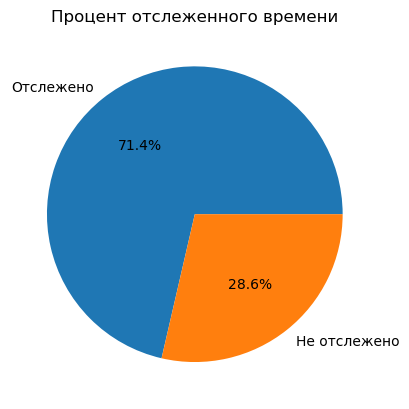

Диапазон отслеживания: 77 days 14:24:18
Всего отслежено: 55 days 09:33:40
Не отслежено: 22 days 04:50:38


In [6]:
# диапазон отслеживаемого времени
start_date = df['time started'].min()
end_date = df['time ended'].max()
interval = end_date - start_date

# всего времени отслежено
sum_duration = df['duration_seconds'].sum()
tracked = pd.to_timedelta(sum_duration, unit='s')

# круговая диаграмма отслеженного времени
percent_time = round(tracked/interval*100, 2)

plt.pie([percent_time, 100 - percent_time], labels = ['Отслежено', 'Не отслежено'], autopct='%1.1f%%')
plt.title('Процент отслеженного времени')
plt.show()

print(f"Диапазон отслеживания: {interval}")
print(f"Всего отслежено: {tracked}")
print(f"Не отслежено: {interval - tracked}")

Значительная часть времени неотслежена. Имеет смысл исследовать неотслеженное время. Возможно включить неотслеженные интервалы в датафрейм как отдельную категорию, но это повлияет на визуальное сравнение категорий, т.к. неотслеженного времени более четверти от общего диапазона.

## Таблица неотслеженного времени

In [7]:
# Сортировка по времени начала
df_sorted = df.sort_values('time started').reset_index(drop=True)

gap_rows = []

for i in range(len(df_sorted) - 1):
    curr_end = df_sorted.loc[i, 'time ended']
    next_start = df_sorted.loc[i + 1, 'time started']
    if next_start > curr_end:
        gap_rows.append({
            'category': 'Неотслежено',
            'time started': curr_end,
            'time ended': next_start,
            'duration_seconds': (next_start - curr_end).total_seconds(),
            'duration_minutes': (next_start - curr_end).total_seconds() / 60
        })

gap_df = pd.DataFrame(gap_rows)
gap_df.head()

,category,time started,time ended,duration_seconds,duration_minutes
0,Неотслежено,2024-09-01 09:00:34,2024-09-01 09:00:41,7.0,0.116667
1,Неотслежено,2024-09-01 09:08:00,2024-09-01 09:18:55,655.0,10.916667
2,Неотслежено,2024-09-01 09:40:44,2024-09-01 09:53:56,792.0,13.200000
3,Неотслежено,2024-09-01 11:20:33,2024-09-01 11:20:55,22.0,0.366667
4,Неотслежено,2024-09-01 11:25:59,2024-09-01 11:36:50,651.0,10.850000


In [24]:
# Исключить нтервалы пропущенного времени, длительностью меньше минуты.
gap_df = gap_df[gap_df['duration_seconds'] >= 60.0]

In [9]:
gap_df.describe()

,time started,time ended,duration_seconds,duration_minutes
count,598,598,598.000000,598.000000
mean,2024-10-13 18:40:42.618729216,2024-10-13 19:39:25.580267264,3522.961538,58.716026
min,2024-09-01 09:08:00,2024-09-01 09:18:55,60.000000,1.000000
25%,2024-09-25 01:57:36,2024-09-25 09:14:11.750000128,210.250000,3.504167
50%,2024-10-16 08:18:37.500000,2024-10-16 08:20:32.500000,461.500000,7.691667
75%,2024-11-01 22:49:02.750000128,2024-11-01 22:56:41.750000128,1106.250000,18.437500
max,2024-11-17 21:56:08,2024-11-17 21:59:20,42683.000000,711.383333
std,NaN,NaN,9152.312089,152.538535


## Распределение длительности неотслеженного времени

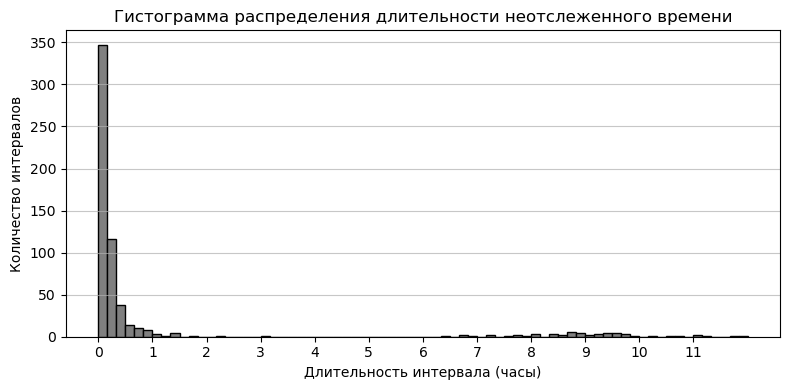

In [10]:
min_value = gap_df['duration_minutes'].min()
max_value = gap_df['duration_minutes'].max()

# Массив границ с шагом 10 минут
bins = np.arange(start=0, stop=max_value + 10, step=10)

plt.figure(figsize=(8, 4))
plt.hist(gap_df['duration_minutes'], bins=bins, color='gray', edgecolor='black')

xticks = np.arange(0, max_value + 1, 60)

plt.xticks(xticks, labels=[str(int(x/60)) for x in xticks])
plt.title('Гистограмма распределения длительности неотслеженного времени')
plt.xlabel('Длительность интервала (часы)')
plt.ylabel('Количество интервалов')
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.show()

Наибольшее количество интервалов не более 10 минут. Есть интервалы длительностью 6-12 часов

## Распределение по часам суток

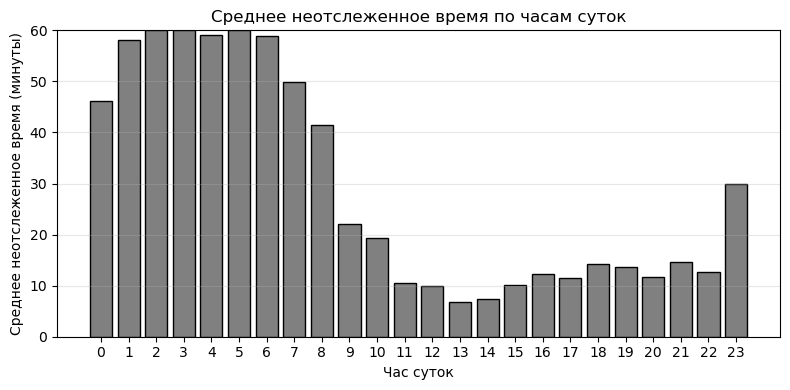

In [11]:
# Интервалы по минутам
minutes_covered = []
for idx, row in gap_df.iterrows():
    start = row['time started']
    end = row['time ended']
    # Диапазон минут, исключая последнюю минуту (полузакрытый интервал)
    minutes = pd.date_range(start, end, freq='min')[:-1]
    for minute in minutes:
        minutes_covered.append({'date': minute.date(), 'hour': minute.hour})

minutes_df = pd.DataFrame(minutes_covered)

# Группировка по дате и часу, рассчет количества покрытых минут
grouped = minutes_df.groupby(['date', 'hour']).size().reset_index(name='minutes_covered')

# Усреднение по датам: среднее покрытое время за каждый час
mean_per_hour = grouped.groupby('hour')['minutes_covered'].mean()

# Визуализация
plt.figure(figsize=(8, 4))
plt.bar(mean_per_hour.index, mean_per_hour.values, color='gray', edgecolor='black')

plt.xlabel('Час суток')
plt.ylabel('Среднее неотслеженное время (минуты)')
plt.title('Среднее неотслеженное время по часам суток')
plt.xticks(range(24))
plt.ylim(0, 60)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Распределение по дням недели

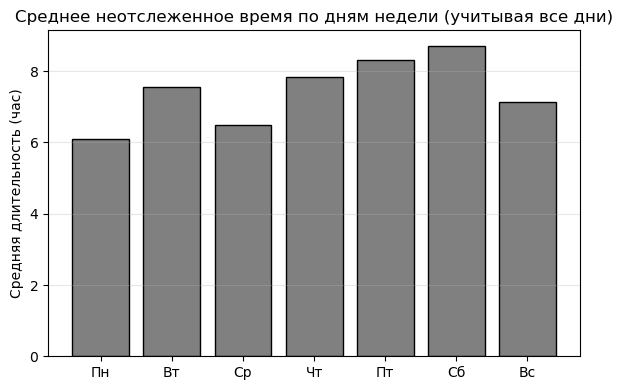

In [12]:
# Добавление даты и дня недели
gap_df['date'] = gap_df['time started'].dt.date
gap_df['weekday'] = gap_df['time started'].dt.dayofweek  # 0=Пн, 6=Вс

# Исключить пересечения во времени
minutes_covered = []
for idx, row in gap_df.iterrows():
    start = row['time started']
    end = row['time ended']
    minutes = pd.date_range(start, end, freq='min')[:-1]  # исключаем последнюю минуту
    for minute in minutes:
        minutes_covered.append({'date': minute.date(), 'weekday': minute.weekday(), 'minute': minute})

minutes_df = pd.DataFrame(minutes_covered)

# Подсчет уникальных минут по дате и дню недели
unique_minutes = minutes_df.groupby(['date', 'weekday'])['minute'].nunique().reset_index(name='minutes_covered')

# Полный список всех дат в диапазоне
all_dates = pd.DataFrame({'date': pd.date_range(gap_df['date'].min(), gap_df['date'].max())})
all_dates['date'] = all_dates['date'].dt.date
all_dates['weekday'] = pd.to_datetime(all_dates['date']).dt.dayofweek

# Объединение с уникальными минутами, пропуски заполняются нулями
full_df = pd.merge(all_dates, unique_minutes, on=['date', 'weekday'], how='left')
full_df['minutes_covered'] = full_df['minutes_covered'].fillna(0)

# Усреднение по дню недели и переводим в часы
mean_gap_by_weekday = full_df.groupby('weekday')['minutes_covered'].mean() / 60

# Визуализация
days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

plt.figure(figsize=(6, 4))
bars = plt.bar(mean_gap_by_weekday.index, mean_gap_by_weekday.values, color='gray', edgecolor='black')

plt.xticks(ticks=range(7), labels=days)
plt.xlabel('')
plt.ylabel('Средняя длительность (час)')
plt.title('Среднее неотслеженное время по дням недели (учитывая все дни)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# Анализ категорий
- Среднее и медианное значения.
- Суммарное время затраченное на каждую категорию
- Количество уникальных дней для каждой категории
- Распределение длительности по категориям
- Распределение по часам суток
- Распределение по дням недели

## Среднее и медиана

In [13]:
df_categories = df.groupby('category')['duration_minutes'].agg(['mean', 'median']).sort_values('category', ascending=True)
df_categories

,mean,median
category,,
Быт,13.721089,9.610
Еда,44.210000,41.820
Образование,55.557479,39.880
Общение,32.851618,23.360
Отдых,32.513374,21.750
Прогулка,29.415479,24.630
Работа,29.300774,23.750
Сон,260.878718,338.820
Спорт,58.002157,12.830


## Время, затраченное на каждую категорию

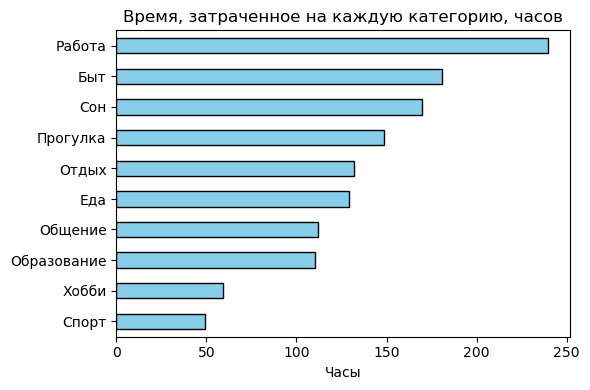

In [14]:
# Группировка по категориям
category_summary = df.groupby('category')['duration_minutes'].sum().sort_values(ascending=False)
category_hours = (category_summary / 60).round(2)

# Горизонтальная столбчатая диграмма для сравнения затраченного времени для каждой категории
category_hours.plot(kind='barh', figsize=(6,4), color='skyblue', edgecolor='black')

plt.xlabel('Часы')
plt.ylabel('')
plt.title('Время, затраченное на каждую категорию, часов')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Количество уникальных дней для каждой категории

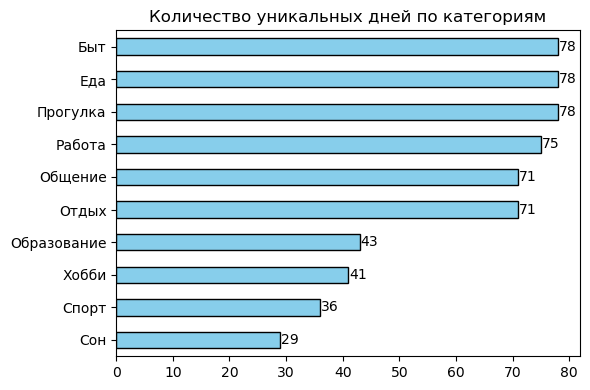

In [15]:
# Добавление колонки с датой
df['date'] = df['time started'].dt.date

# Группировка по категориям и подсчет количества уникальных дней
category_unique_days = df.groupby('category')['date'].nunique().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(6,4))
category_unique_days.plot(kind='barh', color='skyblue', edgecolor='black', ax=ax)

for i, v in enumerate(category_unique_days):
    ax.text(v + 0.1, i, str(v), color='black', va='center')

plt.xlabel('')
plt.ylabel('')
plt.title('Количество уникальных дней по категориям')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

"Сон" отслеживался 29 дней из 78.

## Распределение продолжительности по категориям
- расчет количества групп для гистограммы по формуле Стерджеса

In [16]:
# Расчет количества групп для гистограммы по формуле Стерджеса

def group_number(x):
    return round(3.31 * np.log10(len(x)) + 1)

n = group_number(df['duration_minutes'])
n

12

## Распределение категорий по часам суток

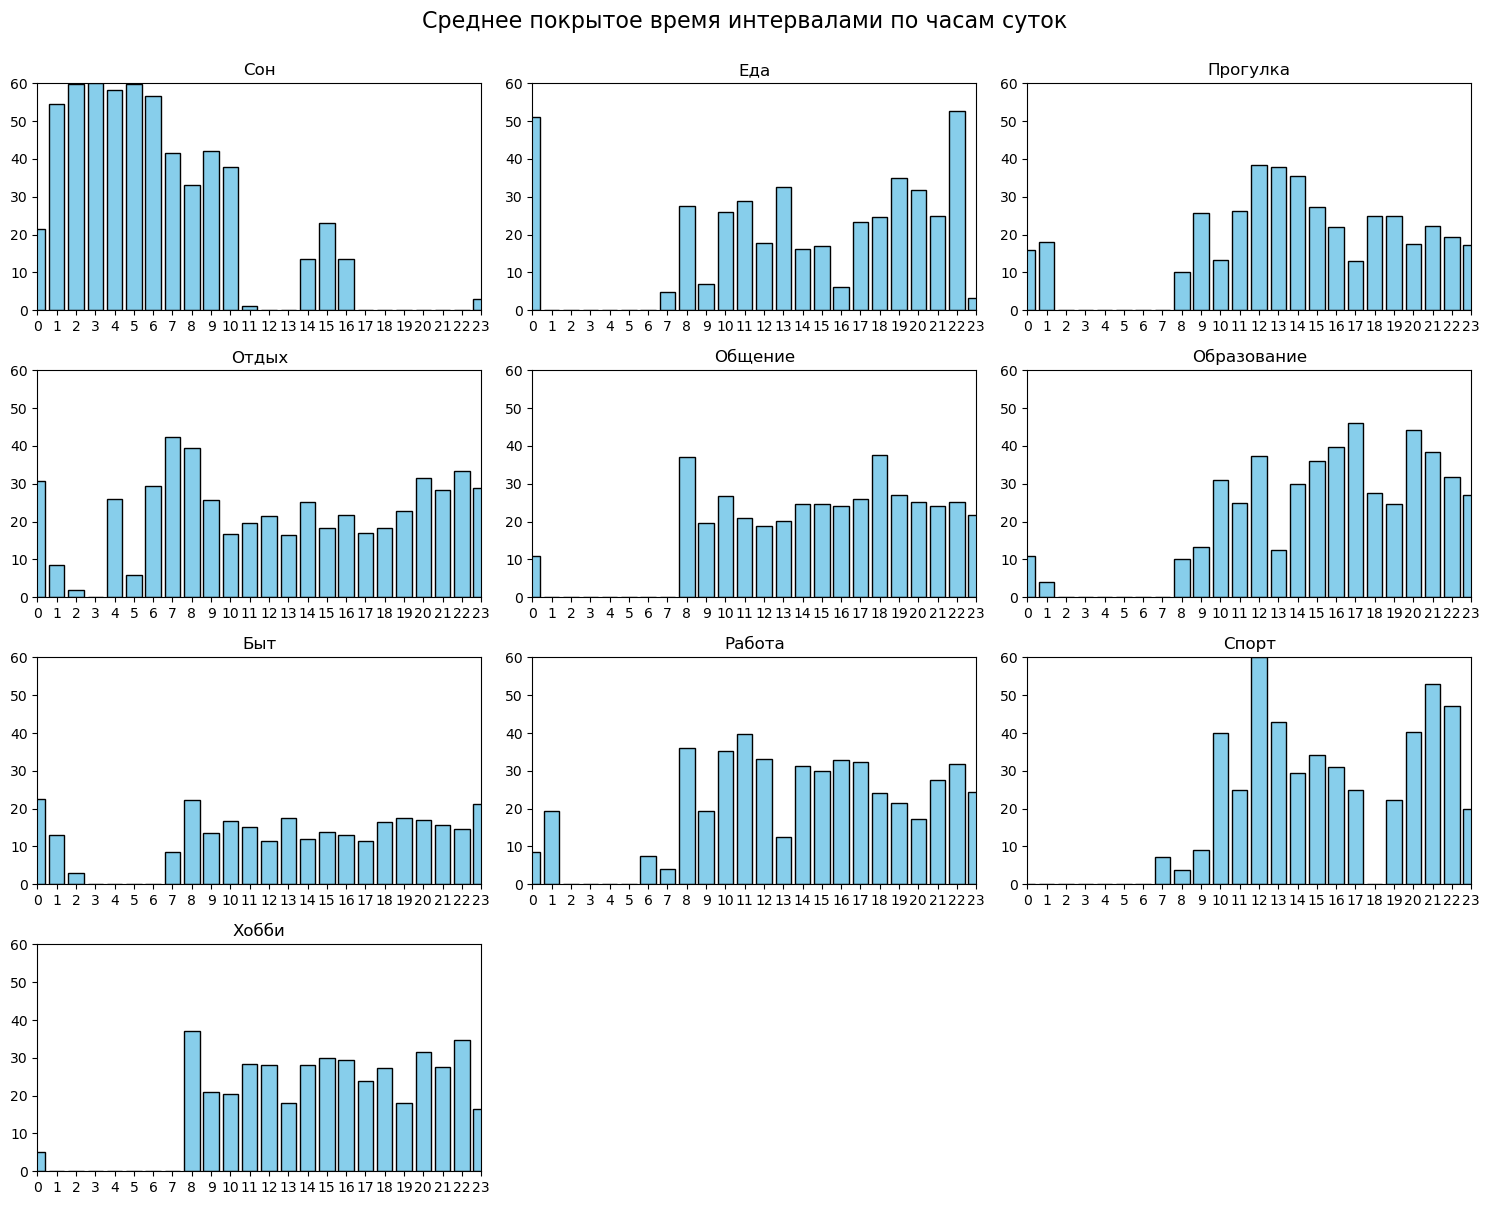

In [17]:
df['time started'] = pd.to_datetime(df['time started'])
df['time ended'] = pd.to_datetime(df['time ended'])

# Список минут, покрываемых каждым интервалом
minutes_covered = []
for idx, row in df.iterrows():
    start = row['time started']
    end = row['time ended']
    minutes = pd.date_range(start, end, freq='min')[:-1]
    for minute in minutes:
        minutes_covered.append({'category': row['category'], 'datetime': minute})

minutes_df = pd.DataFrame(minutes_covered)
minutes_df['hour'] = minutes_df['datetime'].dt.hour
minutes_df['date'] = minutes_df['datetime'].dt.date

# Количество покрытых минут в каждом часу и категории по дням
grouped = minutes_df.groupby(['category', 'hour', 'date'])['datetime'].count().reset_index(name='minutes_covered')

# Среднее количество минут в часе по дням (усредняем по дате)
mean_per_hour = grouped.groupby(['category', 'hour'])['minutes_covered'].mean().reset_index()

# Визуализация
categories = df['category'].unique()
n = len(categories)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3))
axes = axes.flatten()

for i, category in enumerate(categories):
    ax = axes[i]
    hour_data = mean_per_hour[mean_per_hour['category'] == category].set_index('hour')['minutes_covered']
    hour_data = hour_data.reindex(range(24), fill_value=0)
    ax.bar(hour_data.index, hour_data.values, color='skyblue', edgecolor='black')
    ax.set_title(category)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks(range(24))
    ax.set_xlim(0, 23)
    ax.set_ylim(0, 60)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Среднее покрытое время интервалами по часам суток', fontsize=16, y=1)
plt.tight_layout()
plt.show()

## Распределение категорий по дням недели

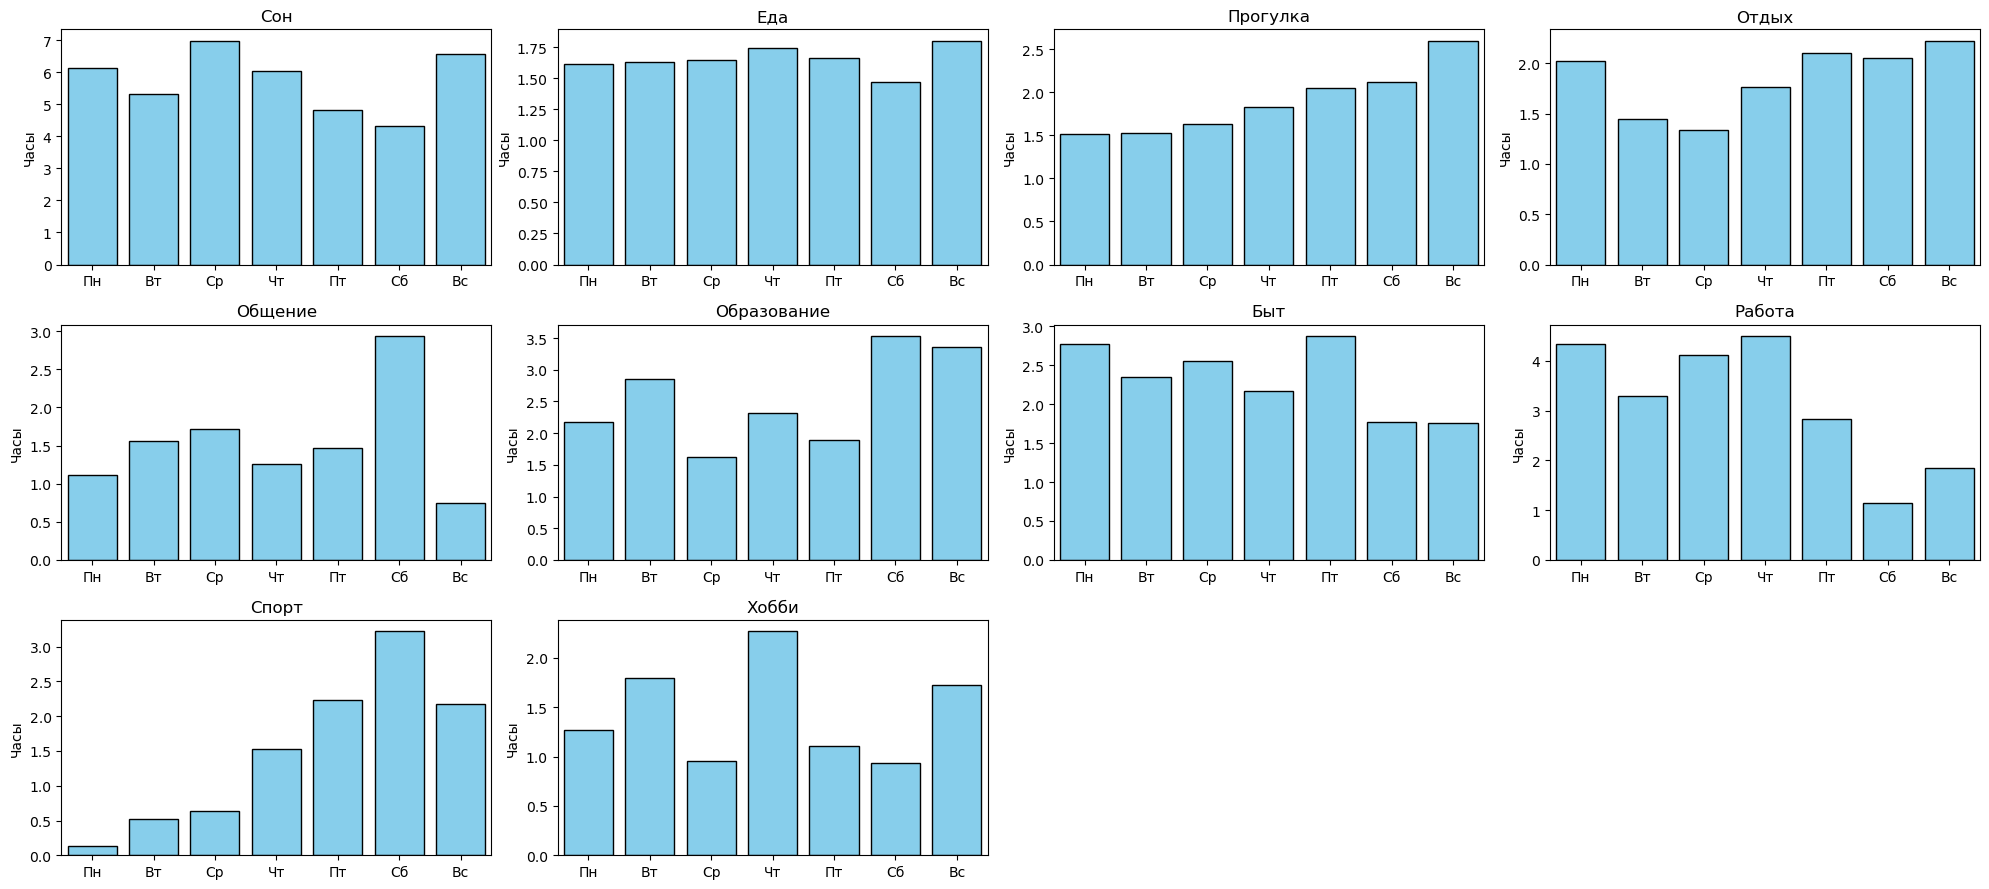

In [18]:
# Добавление колонки с днём недели и датой
df['weekday'] = df['time started'].dt.dayofweek
df['date'] = df['time started'].dt.date

# Суммирование длительности по категории, дню недели и дате
df_daily_sum = df.groupby(['category', 'weekday', 'date'])['duration_minutes'].sum().reset_index()

# Подсчет среднего по категории и дню недели (по уже суммированным дням)
weekday_mean_hours = df_daily_sum.groupby(['category', 'weekday'])['duration_minutes'].mean() / 60

categories = df['category'].unique()
n = len(categories)
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3))
axes = axes.flatten()

for i, category in enumerate(categories):
    ax = axes[i]
    category_mean = weekday_mean_hours.loc[category]
    
    ax.bar(category_mean.index, category_mean.values, color='skyblue', edgecolor='black')
    
    ax.set_title(category)
    ax.set_xlabel('')
    ax.set_ylabel('Часы')
    ax.set_xticks(range(0, 7))
    ax.set_xticklabels(days)
    ax.set_xlim(-0.5, 6.5)

# Убрать пустые подграфики
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Корреляция между категориями
- расчет коэффициента Пирсона для нахождения корреляции между категориями

In [19]:
agg_df = df.groupby(['date', 'category'])['duration_minutes'].sum().unstack(fill_value=0)

# Матрица корреляций
corr_matrix = agg_df.corr()

# Удаление имен индексов, чтобы избежать конфликта
corr_matrix.index.name = None
corr_matrix.columns.name = None

# Преобраование в длинный формат
corr_pairs = corr_matrix.unstack().to_frame(name='Корреляция').reset_index()
corr_pairs.columns = ['Категория 1', 'Категория 2', 'Корреляция']

# Удаление дубликатов и автокорреляции
corr_pairs = corr_pairs[corr_pairs['Категория 1'] < corr_pairs['Категория 2']]

# Фильтр. оставить только те, в которых наблюдается больше |0.3|
corr_pairs = corr_pairs[corr_pairs['Корреляция'].abs() >= 0.3]

# Сортировка по убыванию по модулю корреляции
corr_pairs = corr_pairs.reindex(corr_pairs['Корреляция'].abs().sort_values(ascending=False).index)

corr_pairs = corr_pairs.reset_index(drop=True)

print(corr_pairs)

   Категория 1  Категория 2  Корреляция
0  Образование       Работа   -0.426769
1        Отдых        Хобби   -0.369078
2          Быт  Образование   -0.350046
3          Еда      Общение   -0.325182
4      Общение        Спорт   -0.307402
5       Работа          Сон    0.303868


Наблюдается слабая корреляция (0.3-0.5) между несколькими категориями.
Положиельная слабая корреляция наблюдается только между категориями "Сон" и "Работа". Важно, что расчет идет в рамках одного дня. Также категория "Сон" не всегда отслеживалась.

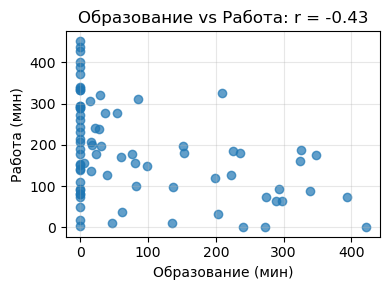

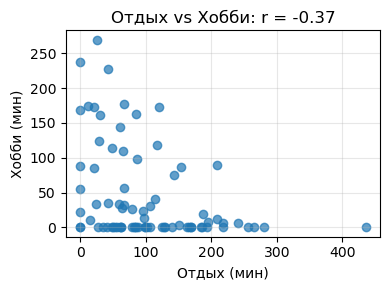

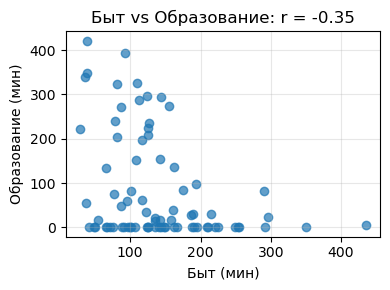

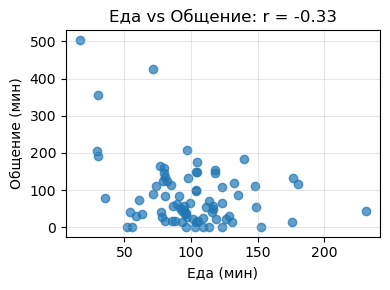

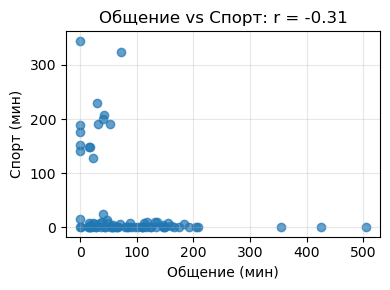

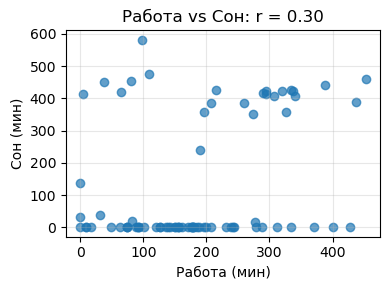

In [20]:
for idx, row in corr_pairs.iterrows():
    cat1 = row['Категория 1']
    cat2 = row['Категория 2']
    r = row['Корреляция']
    
    x = agg_df[cat1]
    y = agg_df[cat2]
    
    plt.figure(figsize=(4, 3))
    plt.scatter(x, y, alpha=0.7)
    plt.xlabel(f'{cat1} (мин)')
    plt.ylabel(f'{cat2} (мин)')
    plt.title(f'{cat1} vs {cat2}: r = {r:.2f}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Корреляция между категориями и неотслеженным временем

In [21]:
agg_gap = gap_df.groupby(['date', 'category'])['duration_minutes'].sum().unstack(fill_value=0)

merged_df = agg_df.join(agg_gap, how='inner')

correlations = merged_df.corr()

# Удаление дубликатов и автокорреляции
corr_with_gap = correlations[['Неотслежено']].drop('Неотслежено')

# Сортировка по убыванию по модулю корреляции
corr_with_gap = corr_with_gap.reindex(corr_with_gap['Неотслежено'].abs().sort_values(ascending=False).index)
corr_with_gap

,Неотслежено
Сон,-0.503968
Общение,0.208128
Работа,-0.163048
Отдых,-0.144639
Образование,0.140696
Еда,-0.139228
Быт,-0.105962
Спорт,-0.073769
Хобби,0.070313
Прогулка,-0.056387


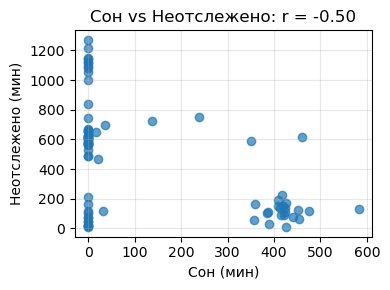

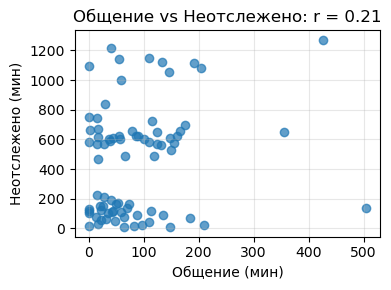

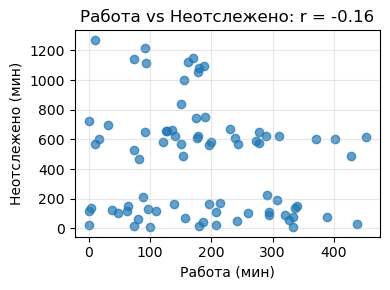

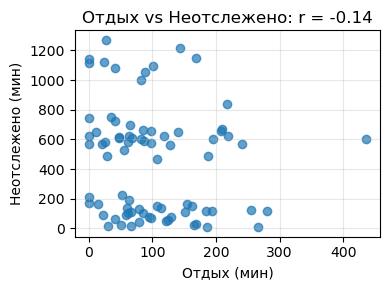

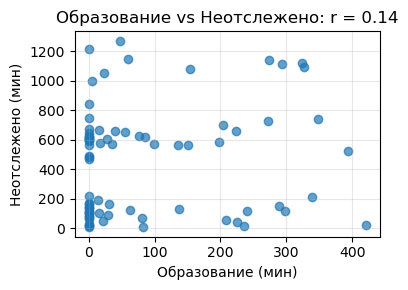

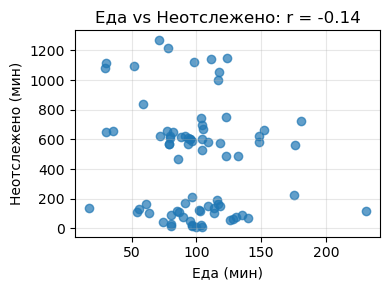

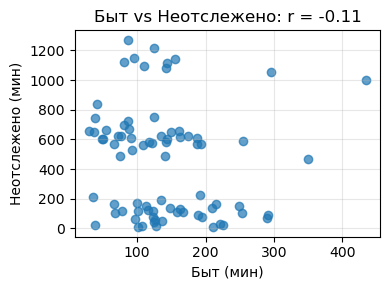

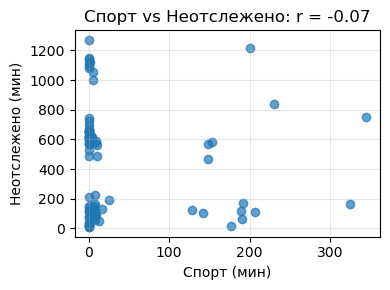

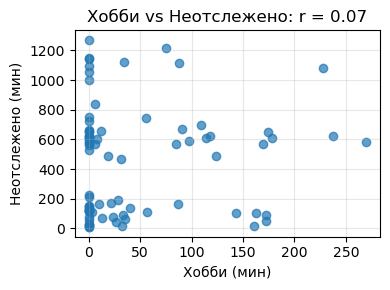

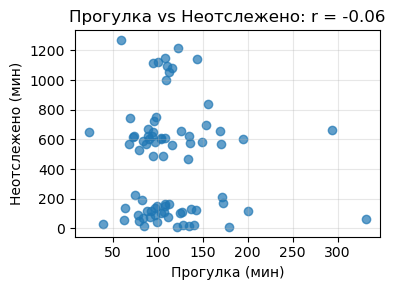

In [22]:
for category in corr_with_gap.index:
    if category == 'Неотслежено':
        continue

    x = merged_df[category]
    y = merged_df['Неотслежено']
    r = corr_with_gap.loc[category, 'Неотслежено']

    mask = x.notna() & y.notna()

    plt.figure(figsize=(4, 3))
    plt.scatter(x[mask], y[mask], alpha=0.7)
    plt.xlabel(f'{category} (мин)')
    plt.ylabel('Неотслежено (мин)')
    plt.title(f'{category} vs Неотслежено: r = {r:.2f}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
